## Attempt to sonify flow of syrian refugees
* Data from UN : http://popstats.unhcr.org/en/asylum_seekers_monthly
* Original code (https://github.com/cirlabs/miditime/blob/master/README.md) transforms the magnitude of an event to the pitch and assumes one data point per event.
* Our data is monthly aggregates. So the magnitude (m) needs to translate to the number of notes (n), rather than mapping m -> pitch (p). 
* Otherwise, it will just sound like a steady stream of beeps, with varying pitch if the month has higher/lower number of refugees, but it's hard for the reader to picture.

In [1]:
# My usual setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas 
from datetime import datetime
import seaborn as sns
import glob
from os.path import basename
sns.set_context('poster') 

In [2]:
# miditime libs
from miditime.miditime import MIDITime 
import numpy as np

## Preprocess data 
* group by month and year (multiple entries per country of origin and even several for each then)
* convert data type
* MAKE SURE SORTED

In [3]:
df = pandas.read_csv('../data/SYRIA-unhcr_popstats_export_asylum_seekers_monthly_2010-2017-06.csv', skiprows=2)

In [4]:
df.head(10)

,Country / territory of asylum/residence,Origin,Year,Month,Value
0,Hungary,Syrian Arab Rep.,2010,January,2
1,Hungary,Syrian Arab Rep.,2010,February,3
2,Hungary,Syrian Arab Rep.,2010,March,1
3,Hungary,Syrian Arab Rep.,2010,April,3
4,Hungary,Syrian Arab Rep.,2010,June,2
5,Hungary,Syrian Arab Rep.,2010,July,3
6,Hungary,Syrian Arab Rep.,2010,August,1
7,Hungary,Syrian Arab Rep.,2010,September,2
8,Hungary,Syrian Arab Rep.,2010,October,4
9,Hungary,Syrian Arab Rep.,2010,November,5


In [5]:
#convert to numeric
df['value_numeric'] = pandas.to_numeric(df.Value, errors="coerce")

In [6]:
# not sure why i have to apply first to convert to string, but here we are.
df['datetime'] = pandas.to_datetime(df.apply(lambda x: str(x['Year']) + x['Month'], axis=1), format="%Y%B")

In [7]:
# There are several records per country per month, get lump sum of each month
monthly_totals = df.groupby('datetime').value_numeric.sum()

In [8]:
monthly_totals.head()

datetime
2010-01-01    499.0
2010-02-01    635.0
2010-03-01    519.0
2010-04-01    433.0
2010-05-01    472.0
Name: value_numeric, dtype: float64

In [9]:
len(monthly_totals.index)

91

In [10]:
MIN = monthly_totals.min()
MAX = monthly_totals.max()

In [11]:
print(MIN)
print(MAX)

433.0
102089.0


In [12]:
monthly_totals = monthly_totals.sort_index()

In [13]:
monthly_totals = monthly_totals.to_frame(name="magnitude")

## Save monthly totals — for easy lookup, then re-read as a dataframe. 
You can skip this step, this is for data documenting. It's also a hack to make a nice df.

In [14]:
monthly_totals.to_csv('../data/monthly-totals-syria.csv')

In [15]:
df = pandas.read_csv('../data/monthly-totals-syria.csv', parse_dates=['datetime'])

In [16]:
df.head(10)

,datetime,magnitude
0,2010-01-01,499.0
1,2010-02-01,635.0
2,2010-03-01,519.0
3,2010-04-01,433.0
4,2010-05-01,472.0
5,2010-06-01,455.0
6,2010-07-01,459.0
7,2010-08-01,604.0
8,2010-09-01,602.0
9,2010-10-01,634.0


### Chart data

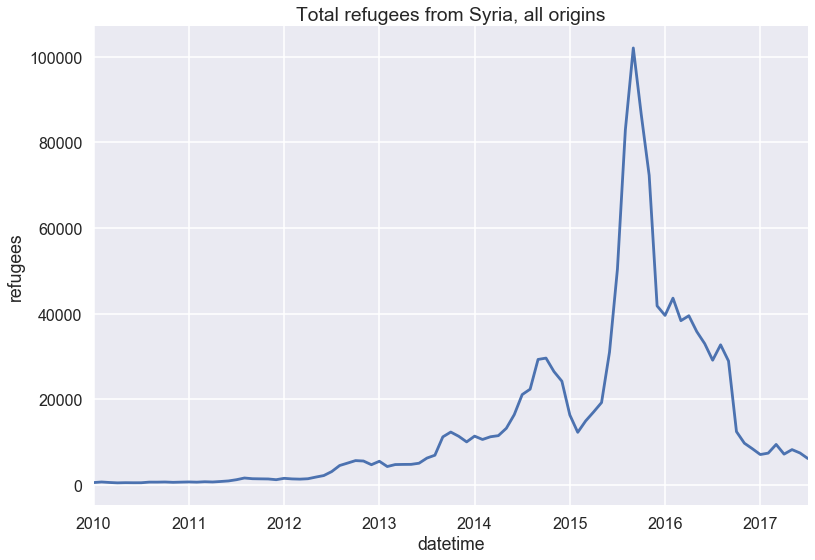

In [24]:
df.plot('datetime')
plt.title("Total refugees from Syria, all origins")
plt.legend("")
plt.ylabel("refugees")

## Process for MIDI
* CHANGES FROM REVEAL CODE: DO EVERYTHING IN A DF

Instantiate the class with a tempo (120bpm is the default), an output file destination, the number of seconds you want to represent a year in the final song (default is 5 sec/year), the base octave (C5 is middle C, so the default is 5, and how many octaves you want your output to range over (default is 1).

In [18]:
BPM = 120
FILENAME = '../audio/syria-2010-2017-FREQ.mid'
SEC_PER_YEAR = 6
BASE_OCTAVE = 5
OCTAVES = 1

mymidi = MIDITime(BPM,FILENAME, SEC_PER_YEAR, BASE_OCTAVE, OCTAVES)

I save this is as a column, and zip all data later, for easy error checking.
Convert your date/time data into an integer, like days since the epoch (Jan. 1, 1970). You can use the days_since_epoch() helper method, or not:

In [19]:
df['epoched'] = df.datetime.apply(lambda x: mymidi.days_since_epoch(x))

Convert your integer date/time to something reasonable for a song. For example, at 120 beats per minute, you'll need to scale the data down a lot to avoid a very long song if your data spans years. This uses the seconds_per_year attribute you set at the top, so if your date is converted to something other than days you may need to do your own conversion. But if your dataset spans years and your dates are in days (with fractions is fine), use the beat() helper method.

In [20]:
df['beat'] = df['epoched'].apply(lambda x: mymidi.beat(x))

In [21]:
START_TIME = df.beat.min() # beat doesn't start at 0 since we scaled our epoch seconds, so we just start at the first one.
print(START_TIME)

480.0


In [22]:
df.head()

,datetime,magnitude,epoched,beat
0,2010-01-01,499.0,14610.0,480.00
1,2010-02-01,635.0,14641.0,481.02
2,2010-03-01,519.0,14669.0,481.94
3,2010-04-01,433.0,14700.0,482.96
4,2010-05-01,472.0,14730.0,483.94


In [23]:
df.magnitude.max()

102089.0

Set up some functions to scale your other variable (magnitude in our case) to match your desired mode/key and octave range. There are helper methods to assist this scaling, very similar to a charting library like D3. You can choose a linear or logarithmic scale.

## Calculate N, the number of beats we want for a given month, as a function of magnitude.
We use numpy linear interpolation to map. (maybe add logarithmic later.) We don't need to reverse it, because higher number of refugees = more notes.

In [24]:
MIN_N = 1 # how many notes do we want per month min?
MAX_N = 10 # how many notes do we want per month max?

df['N'] = df.magnitude.apply(lambda x: np.interp(x, [MIN,MAX], [MIN_N, MAX_N]))

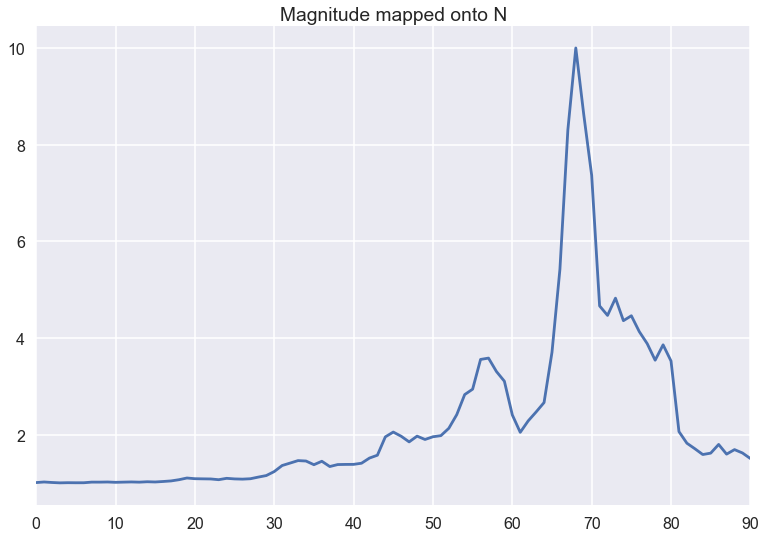

In [25]:
df.head() 
df.N.plot()
plt.title("Magnitude mapped onto N")

## Time to make the note list!
* I know you're not supposed to iterate through a dataframe — but it's pretty small and manegable.
* [BEAT, PITCH, VELOCITY (VOLUME), DURATION_OF_NOTE]


In [26]:
months = df.to_dict('records')

In [27]:
df.N

0      1.005843
1      1.017884
2      1.007614
3      1.000000
4      1.003453
5      1.001948
6      1.002302
7      1.015139
8      1.014962
9      1.017795
10     1.010978
11     1.015139
12     1.018769
13     1.014431
14     1.022930
15     1.018149
16     1.028242
17     1.040017
18     1.065249
19     1.100220
20     1.085966
21     1.083045
22     1.080566
23     1.065427
24     1.093669
25     1.081628
26     1.076936
27     1.085258
28     1.119432
29     1.151127
        ...    
61     2.045939
62     2.282148
63     2.467449
64     2.661958
65     3.702939
66     5.421736
67     8.304753
68    10.000000
69     8.625600
70     7.364346
71     4.661850
72     4.465482
73     4.822539
74     4.356585
75     4.458045
76     4.129761
77     3.880450
78     3.538443
79     3.856546
80     3.521179
81     2.060636
82     1.820443
83     1.706589
84     1.586183
85     1.615222
86     1.794857
87     1.594505
88     1.687908
89     1.618586
90     1.503050
Name: N, Length: 91, dty

In [28]:
note_list = [] 
P = 71 # for now constant
V = 100

for i in range(len(months)-1):
    start_beat = months[i]['beat']
    end_beat = months[i+1]['beat']
    period = end_beat - start_beat
    N = round(months[i]['N']) # truncate the N to nearest int
    
    for n in range(N):  
        #print(N)
        beat = start_beat + (n * (period/N))
        pitch = P 
        velocity = V
        duration = (period / N) - (period/100)  # do a little offset?
        note_list.append([beat - START_TIME, pitch, velocity, duration])
    

In [29]:
#note_list

In [30]:
len(note_list)


200

## Make MIDI file

In [31]:
# Add a track with those notes
mymidi.add_track(note_list)

# Output the .mid file
mymidi.save_midi()

71 0.0 1.009799999999982 100
71 1.02 0.9108000000000157 100
71 1.94 1.009799999999982 100
71 2.96 0.970200000000018 100
71 3.94 1.009799999999982 100
71 4.96 0.980100000000009 100
71 5.95 1.0098000000000382 100
71 6.97 0.999899999999991 100
71 7.98 0.980100000000009 100
71 8.97 1.009799999999982 100
71 9.99 0.970200000000018 100
71 10.97 1.009799999999982 100
71 11.99 1.009799999999982 100
71 13.01 0.9108000000000157 100
71 13.93 1.009799999999982 100
71 14.95 0.970200000000018 100
71 15.93 1.009799999999982 100
71 16.95 0.980100000000009 100
71 17.94 1.009799999999982 100
71 18.96 1.0098000000000382 100
71 19.98 0.9701999999999618 100
71 20.96 1.0098000000000382 100
71 21.98 0.980100000000009 100
71 22.97 0.999899999999991 100
71 23.98 1.009799999999982 100
71 25.0 0.9404999999999888 100
71 25.95 1.0098000000000382 100
71 26.97 0.9800999999999527 100
71 27.96 1.0098000000000382 100
71 28.98 0.9701999999999618 100
71 29.96 1.0098000000000382 100
71 30.98 1.009799999999982 100
71 32.0 0